In [9]:
#import libraries and set the vectorBT portfolio settings

import numpy as np
import pandas as pd

np.random.seed(42)

In [10]:
import datetime as dt
# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']


# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[prices.index <= dt.datetime(2023, 12, 30)]

In [11]:
limite_superior = 75
limite_inferior = 28

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [12]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados


True


In [13]:
import riskfolio as rp
import pandas as pd

# Função de otimização
def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Verifica se o grupo tem dados suficientes para a otimização
    if len(grupo) < 252 * 2:
        return None  # Retorna None se não houver dados suficientes

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# Função para obter os dias úteis trimestrais
def get_quarterly_business_days(prices):
    start_date = prices.index[0]
    end_date = prices.index[-1]
    
    # Lista para armazenar as datas trimestrais
    quarterly_dates = []
    current_date = start_date
    
    while current_date <= end_date:
        # Se a data atual não for dia útil, ajusta para o próximo dia útil
        if current_date.weekday() >= 5:  # Sábado (5) ou domingo (6)
            current_date += pd.offsets.BDay()
        
        # Adiciona a data ajustada à lista
        quarterly_dates.append(current_date)
        
        # Avança 3 meses
        current_date += pd.DateOffset(months=3)
    
    # Cria uma Series com essas datas como índice e valores `True`
    rebalancear_trimestres = pd.Series(index=quarterly_dates, data=True)
    rebalancear_trimestres = rebalancear_trimestres.reindex(prices.index, fill_value=False)
    
    return rebalancear_trimestres

# Gerando as datas trimestrais
prices.sort_index(inplace=True)
rebalancear_trimestres = get_quarterly_business_days(prices)

# Aplicando a otimização
pesos_trimestrais = pd.DataFrame()
for data, entry in rebalancear_trimestres.items():
    if entry:
        w = optimization(prices, data)
        if w is not None:
            w = w.T
            w.index = [data]
            pesos_trimestrais = pd.concat([pesos_trimestrais, w], axis=0)

pesos_trimestrais


,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-08-19,9.263958e-03,5.079621e-03,4.682526e-10,5.222148e-10,5.550466e-10,3.168013e-09,1.198692e-09,1.203111e-02,1.727792e-03,8.765929e-10,...,0.018910,5.385671e-09,2.963147e-03,0.005246,2.677318e-09,8.342402e-10,1.576220e-09,8.036793e-03,3.446419e-02,2.708507e-09
2015-11-19,5.479949e-03,5.955289e-04,2.634917e-10,4.404745e-10,4.031395e-10,1.569319e-09,8.020647e-10,1.999412e-02,3.944106e-03,8.167543e-10,...,0.027068,8.268101e-04,1.300697e-08,0.005270,2.193240e-09,1.665950e-03,1.001056e-09,1.477766e-02,2.705270e-02,6.575834e-09
2016-02-19,1.949265e-03,3.871756e-03,1.024529e-09,1.908832e-09,1.625495e-09,3.513858e-09,1.747698e-09,1.833252e-02,5.313619e-03,2.097897e-09,...,0.025486,2.166519e-08,6.159020e-08,0.003263,5.003136e-09,9.044838e-04,2.811920e-09,9.331013e-03,1.892016e-02,5.919530e-09
2016-05-19,1.579700e-02,6.781352e-03,8.215308e-11,1.574993e-10,1.274354e-10,2.786875e-04,1.573498e-10,1.320010e-02,5.770003e-03,2.301888e-10,...,0.030657,9.307201e-10,2.180877e-09,0.009055,9.590242e-10,5.545269e-10,1.843003e-10,5.182186e-03,1.790670e-02,4.258954e-10
2016-08-19,1.902391e-02,5.983156e-03,1.192296e-09,2.570368e-09,2.016997e-09,3.734646e-04,1.911707e-09,1.098024e-02,4.211742e-03,3.209018e-09,...,0.023966,1.557301e-08,1.282859e-08,0.013781,2.525720e-08,3.244199e-09,2.126467e-09,3.867855e-03,1.627511e-02,7.511333e-09
2016-11-21,3.019473e-02,9.055340e-03,4.644915e-10,1.129117e-09,8.495136e-10,5.279473e-03,5.850483e-10,1.136978e-02,1.992312e-03,1.325126e-09,...,0.020503,1.543735e-08,3.544882e-09,0.013581,6.717526e-03,6.737152e-10,6.652945e-10,1.936305e-03,6.711886e-03,2.634536e-09
2017-02-21,4.808040e-02,2.433075e-02,5.777978e-10,1.456588e-09,1.008027e-09,2.353542e-02,6.751229e-10,2.514950e-02,1.020641e-02,1.480192e-09,...,0.032672,1.458802e-08,4.331764e-09,0.034743,2.975612e-02,7.376191e-10,8.264201e-10,5.727755e-03,4.985918e-03,2.412773e-09
2017-05-22,4.880487e-02,2.114957e-02,7.539644e-10,1.671673e-09,1.319186e-09,4.057598e-02,9.521166e-10,1.787008e-02,1.387443e-02,1.562121e-09,...,0.028965,1.078042e-08,7.478673e-09,0.029637,3.110266e-02,8.660651e-10,1.283061e-09,1.718751e-08,4.895367e-03,2.472934e-09
2017-08-22,5.611906e-02,1.837357e-02,9.445052e-10,2.099947e-09,1.757167e-09,4.513383e-02,1.183846e-09,8.992704e-03,1.976169e-02,2.007733e-09,...,0.029143,3.796563e-09,5.107538e-03,0.033237,2.721840e-02,1.045562e-09,1.552461e-09,1.136701e-08,1.970052e-03,2.529010e-09
2017-11-22,5.705930e-02,1.642967e-02,1.777100e-10,4.202638e-10,3.428977e-10,5.135292e-02,2.359616e-10,2.940103e-09,1.507635e-02,3.735462e-10,...,0.023326,9.714208e-10,1.412874e-02,0.051299,2.898249e-02,1.417343e-10,3.480549e-10,1.806389e-08,1.074658e-09,6.216489e-10


In [ ]:
import riskfolio as rp
import pandas as pd

# TODO: Verificar quantidade de tempo para rebalanceamento
# TODO: Constraints da otimização
def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # Usando Ledoit-Wolf shrinkage para tornar a matriz de cov positiva definida

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MinRisk'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-08-07,9.402251e-03,5.369620e-03,9.543454e-10,9.318886e-10,1.044926e-09,6.436507e-09,3.958341e-09,1.041723e-02,1.083302e-03,1.516685e-09,...,0.018254,1.031611e-08,3.568228e-03,0.004270,5.138091e-09,2.758947e-09,7.961301e-09,1.013961e-02,3.545822e-02,3.923637e-09
2015-08-11,9.850659e-03,5.472303e-03,5.774198e-10,5.631422e-10,6.345056e-10,3.782597e-09,2.166896e-09,1.052760e-02,1.093353e-03,9.125689e-10,...,0.018135,6.638760e-09,3.572930e-03,0.004378,3.187379e-09,1.604514e-09,4.165951e-09,9.735186e-03,3.546259e-02,2.444290e-09
2015-08-13,9.828682e-03,5.053541e-03,3.757928e-10,4.230231e-10,4.503312e-10,1.981140e-09,8.973094e-10,1.120943e-02,1.071974e-03,6.776589e-10,...,0.018661,2.093362e-09,3.170017e-03,0.005017,1.700285e-09,6.615267e-10,8.744966e-10,7.843250e-03,3.416405e-02,1.374407e-09
2015-08-24,1.023942e-02,5.796098e-03,5.097097e-09,5.558426e-09,6.052018e-09,5.291666e-08,1.405686e-08,1.166633e-02,1.604743e-03,9.520285e-09,...,0.017568,5.199495e-08,2.271003e-03,0.004872,3.445506e-08,8.111614e-09,2.209649e-08,7.893029e-03,3.303802e-02,7.921423e-08
2015-09-01,1.053908e-02,5.154342e-03,1.467789e-09,1.611807e-09,1.711283e-09,1.447664e-08,3.605628e-09,1.211682e-02,2.572201e-03,2.763377e-09,...,0.016851,8.742835e-09,1.524636e-03,0.003749,8.226479e-09,2.519998e-09,4.475698e-09,7.365863e-03,3.285632e-02,4.460501e-08
2015-09-22,1.093866e-02,6.313835e-03,3.212266e-09,3.698040e-09,3.752490e-09,4.393922e-08,1.015886e-08,1.410225e-02,3.327835e-03,5.831330e-09,...,0.016068,2.659448e-08,1.651361e-03,0.004018,2.247343e-08,8.113070e-09,1.110388e-08,7.830996e-03,3.143604e-02,2.924280e-07
2015-09-24,1.091139e-02,5.714737e-03,4.303925e-09,4.977932e-09,5.070217e-09,5.148121e-08,1.296098e-08,1.495240e-02,3.621349e-03,7.583973e-09,...,0.016947,5.020503e-08,1.627865e-03,0.003584,3.010611e-08,9.269420e-09,1.416056e-08,7.132399e-03,3.105400e-02,8.035543e-07
2015-10-06,1.102487e-02,4.559213e-03,1.298737e-09,1.575718e-09,1.617407e-09,2.127266e-08,3.618377e-09,1.500170e-02,3.477727e-03,2.354583e-09,...,0.016256,1.155923e-08,8.661290e-04,0.003411,8.610604e-09,2.877320e-09,3.914450e-09,7.656638e-03,2.963761e-02,1.773138e-08
2015-11-10,5.705222e-03,1.952299e-03,5.738831e-10,9.518922e-10,8.773109e-10,3.480422e-09,1.762580e-09,2.036897e-02,4.829806e-03,1.768770e-09,...,0.026194,8.876861e-04,9.587956e-09,0.004242,4.506232e-09,8.419397e-04,2.298157e-09,1.551015e-02,2.726791e-02,1.133793e-08
2015-11-12,5.585793e-03,1.257960e-03,1.083190e-09,1.783775e-09,1.627675e-09,6.248031e-09,3.291276e-09,2.039070e-02,4.283018e-03,3.259047e-09,...,0.026783,9.716501e-04,2.418162e-08,0.005168,7.892561e-09,6.895413e-04,4.451904e-09,1.463956e-02,2.669155e-02,1.639074e-08


[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


<Axes: title={'center': 'Equity Progression'}>

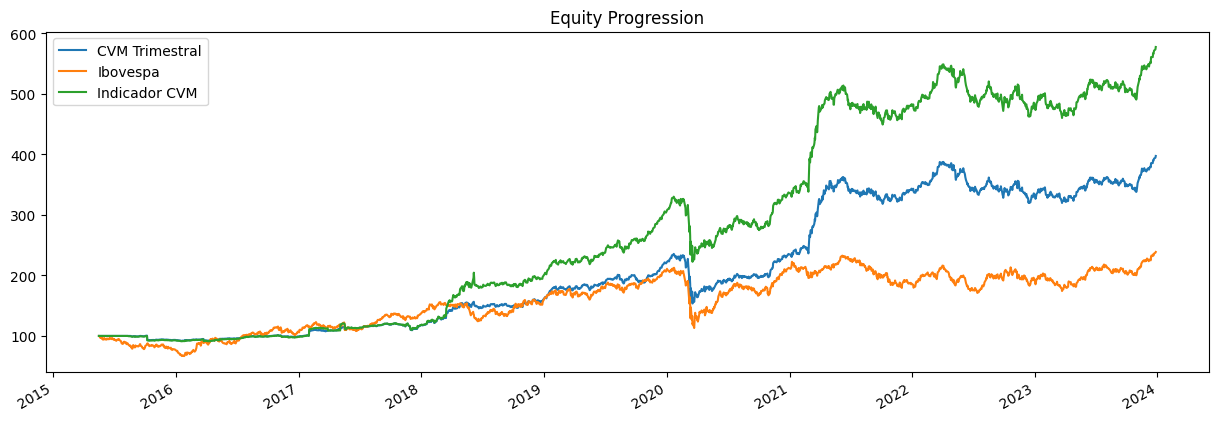

In [15]:
prices = prices[prices.index >= indicadores.index.min()]

# Assumindo que você já tem um DataFrame 'prices' com os dados de preços de ações
# Exemplo:
# prices = yf.download(['AAPL', 'MSFT', 'GOOG'], start='2020-01-01', end='2024-01-01')['Adj Close']

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia CVM trimestral
strat_cvm_trimestral = bt.Strategy('CVM Trimestral', [
    bt.algos.WeighTarget(pesos_trimestrais),
    bt.algos.Rebalance()
])


# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador CVM', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])
# Criando o backtest
backtests = [
    bt.Backtest(strat_cvm_trimestral, prices, initial_capital=1000000000),
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()


In [16]:
# Resultados
results.display()

Stat                 CVM Trimestral    Ibovespa    Indicador CVM
-------------------  ----------------  ----------  ---------------
Start                2015-05-17        2015-05-17  2015-05-17
End                  2023-12-27        2023-12-27  2023-12-27
Risk-free rate       0.00%             0.00%       0.00%

Total Return         297.43%           138.76%     477.55%
Daily Sharpe         1.03              0.54        1.21
Daily Sortino        1.60              0.84        2.01
CAGR                 17.37%            10.63%      22.58%
Max Drawdown         -34.80%           -46.82%     -32.59%
Calmar Ratio         0.50              0.23        0.69

MTD                  6.29%             5.39%       6.20%
3m                   14.50%            17.38%      14.88%
6m                   11.84%            14.19%      12.40%
YTD                  18.43%            21.96%      18.96%
1Y                   20.33%            23.86%      21.00%
3Y (ann.)            19.16%            4.08%       1

In [17]:
trans = results.get_transactions('Indicador CVM')
trans

price   quantity
Date       Security                       
2015-08-07 ABEV3.SA   14.226474   660898.0
           ALPA4.SA    5.404266   993589.0
           BRAP4.SA    1.493313        2.0
           BRFS3.SA   65.516464   159001.0
           BRKM5.SA    8.704030   124459.0
...                         ...        ...
2023-12-14 TAEE11.SA  34.128860  2113792.0
           TIMS3.SA   17.333977 -2055880.0
           TRPL4.SA   23.760000 -3342352.0
           VALE3.SA   67.781174   409877.0
           VIVT3.SA   51.649788  -203303.0

[1208 rows x 2 columns]

In [18]:
import pandas as pd

opt = pd.read_csv('./data/resultados_otimization.csv')

opt.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
opt.loc[np.argmax(opt['total_return']), ['limite_inferior', 'limite_superior', 'obj', 'total_return']]

limite_inferior           28
limite_superior           80
obj                   MaxRet
total_return       71.357829
Name: 472, dtype: object

In [20]:
opt2 = opt[opt['obj'] == 'MinRisk'].reset_index(drop=True)
opt2.loc[np.argmax(opt2['total_return']), ['limite_inferior', 'limite_superior', 'obj', 'total_return']]

limite_inferior         21
limite_superior         76
obj                MinRisk
total_return       6.49831
Name: 67, dtype: object

In [21]:
# Clareza
# Todas as variáveis de decisão
# Explicar todas as decisões
# Todos os resultados anualizados


# Testar o k-flod CV

In [22]:
# 1 - Preparar o Relatório
# - Falar do sentimento - Focar no timing de reotimização
# - Finanças comportamentais - índices de sentimento
# Mostrar visualmente tbm nossa estrategia, por exemplo mostrar quando o indices passou pela banda
# 2 - Preparar para apresentação

